In [1]:
# import module libraries
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

In [2]:
# LSTM with layer normalization
class LayerNormLSTM(nn.Module):
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_i = nn.Linear(input_node, 4*hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4*hidden_node, bias=False)

        self.ln_i = nn.LayerNorm(hidden_node)
        self.ln_f = nn.LayerNorm(hidden_node)
        self.ln_w = nn.LayerNorm(hidden_node)
        self.ln_o = nn.LayerNorm(hidden_node)
        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden

        gi = self.w_i(input)
        gh = self.w_h(h_prev)
        i_i, i_f, i_w, i_o = gi.chunk(4, dim=-1)
        h_i, h_f, h_w, h_o = gh.chunk(4, dim=-1)

        i_g = torch.sigmoid(self.ln_i(i_i + h_i))
        f_g = torch.sigmoid(self.ln_f(i_f + h_f))
        w_g = torch.tanh(self.ln_w(i_w + h_w))
        o_g = torch.sigmoid(self.ln_o(i_o + h_o))
        

        c_new = f_g * c_prev + i_g * w_g
        c_new = self.ln_c(c_new)

        h_new = o_g * torch.tanh(c_new)

        return h_new, c_new

In [3]:
# State feature extractor using LayerNorm LSTM
class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for i in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(hidden_node)

    def forward(self, x, seq_len):
        batch_size, max_len, _ = x.size()
        device = x.device

        h_states = []
        c_states = []

        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))

        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t # initialize layer input with input tensor
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)

        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        normed_output = self.layernorm(masked_output)
        return self.dropout(normed_output)

In [4]:
# Physical change regressor
class PhysRegr(nn.Module):
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.LayerNorm(hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.LayerNorm(hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, output_node))
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)

In [5]:
# Current regressor
class CurrRegr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.LayerNorm(hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.LayerNorm(hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)   

In [6]:
# Physical Constraint Layer
class PhysConstr(nn.Module):
    def __init__(self, range_mm, curr_regr, eps=1e-2):
        super().__init__()
        
        self.eps = eps
        self.curr_regr = curr_regr
        self.register_buffer('range_mm_tensor',self._range2tensor(range_mm))

    def _range2tensor(self, range_mm):
        feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
        ranges = torch.zeros(len(feature_names), 2)

        for i, name in enumerate(feature_names):
            ranges[i, 0] = range_mm[name]['min']
            ranges[i, 1] = range_mm[name]['max']

        return ranges

    def _norm_tensor(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def _denorm_tensor(self, norm_data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return norm_data * (max_val - min_val) + min_val

    def forward(self, phys_chng, cur_state, fin, initV):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self._denorm_tensor(cur_state[..., 2:3], VF_idx)
        VA = self._denorm_tensor(cur_state[..., 3:4], VA_idx)
        VB = self._denorm_tensor(cur_state[..., 4:5], VB_idx)
        CFLA = self._denorm_tensor(cur_state[..., 5:6], CFLA_idx)
        CALA = self._denorm_tensor(cur_state[..., 6:7], CALA_idx)
        CFK = self._denorm_tensor(cur_state[..., 7:8], CFK_idx)
        CBK = self._denorm_tensor(cur_state[..., 8:9], CBK_idx)

        ## Flow in parameters
        FvF, FvA, FvB, CiLA, CiK = fin

        VFi, VAi, VBi = initV

        dVF_in, dVA_in, dVB_in = FvF, FvA, FvB
        dNFLA_in, dNFK_in = FvF * CiLA, FvF * CiK

        rdVA = phys_chng[..., 0:1]
        rdVB = phys_chng[..., 1:2]
        rdNALA = phys_chng[..., 2:3]
        rdNBK = phys_chng[..., 3:4]

        ## Mass Balance
        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        dVA = VF*(rdVA -0.5)
        dVB = VF*(rdVB - 0.5)
        dNBK = NFK*rdNBK
        dNALA = NFLA*rdNALA

        ### new states before discharge
        nVF_bf = VF - dVA - dVB + dVF_in
        nVA_bf = VA + dVA + dVA_in
        nVB_bf = VB + dVB + dVB_in

        nNFLA_bf = NFLA - dNALA + dNFLA_in
        nNALA_bf = NALA + dNALA
        nNFK_bf = NFK - dNBK + dNFK_in
        nNBK_bf = NBK + dNBK

        nCFLA = nNFLA_bf / nVF_bf
        nCALA = nNALA_bf / nVA_bf
        nCFK = nNFK_bf / nVF_bf
        nCBK = nNBK_bf / nVB_bf

        

        dVF_out = nVF_bf - VFi
        dVA_out = nVA_bf - VAi
        dVB_out = nVB_bf - VBi

        nVF = nVF_bf - dVF_out
        nVA = nVA_bf - dVA_out
        nVB = nVB_bf - dVB_out
        
        dNFLA_out, dNFK_out = nCFLA*dVF_out, nCFK*dVF_out

        dNALA_out = nCALA*dVA_out
        dNBK_out = nCBK*dVB_out

        ### Final new states
        nNFLA = nNFLA_bf - dNFLA_out
        nNALA = nNALA_bf - dNALA_out
        nNFK = nNFK_bf - dNFK_out
        nNBK = nNBK_bf - dNBK_out

        V = cur_state[..., 0:1]
        E = cur_state[..., 1:2]

        nVF_norm = self._norm_tensor(nVF, VF_idx)
        nVA_norm = self._norm_tensor(nVA, VA_idx)
        nVB_norm = self._norm_tensor(nVB, VB_idx)
        nCFLA_norm = self._norm_tensor(nCFLA, CFLA_idx)
        nCALA_norm = self._norm_tensor(nCALA, CALA_idx)
        nCFK_norm = self._norm_tensor(nCFK, CFK_idx)
        nCBK_norm = self._norm_tensor(nCBK, CBK_idx)

        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)

        nI_pred = self.curr_regr(temp_state)
        nI_real = self._denorm_tensor(nI_pred, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self._norm_tensor(nI_real, I_idx)

        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)

        ### discharge
        discharge = {
            'VF': dVF_out,
            'VA': dVA_out,
            'VB': dVB_out,
            'NFLA': dNFLA_out,
            'NALA': dNALA_out,
            'NFK': dNFK_out,
            'NBK': dNBK_out,
            'CFLA': nCFLA,
            'CALA': nCALA,
            'CFK': nCFK,
            'CBK': nCBK
        }

        return next_state, discharge

In [7]:
# BMED model
class BMEDModel(nn.Module):
    def __init__(self, state_extr_params, phys_regr_params, curr_regr_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.phys_regr = PhysRegr(**phys_regr_params)
        self.curr_regr = CurrRegr(**curr_regr_params)
        self.phys_constr = PhysConstr(range_mm, self.curr_regr)

        self._hidden_states = None
        self._cell_states = None

    def _reset_hidden_states(self, batch_size, device):
        self._hidden_states = []
        self._cell_states = []
        for _ in range(self.state_extr.n_layer):
            self._hidden_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))
            self._cell_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))

    def cont_sim(self, init_state, target_len, fin, initV):
        batch_size = init_state.size(0)
        feature_size = init_state.size(1)
        device = init_state.device

        self._reset_hidden_states(batch_size, device)

        pred = torch.zeros(batch_size, target_len, feature_size, device=device)
        discharge_record = []
        cur_state = init_state.clone()

        for t in range(target_len):
            pred[:, t, :] = cur_state

            if t < target_len - 1:
                lstm_input = cur_state[:, :-1] # except current
                hidden_output = self._lstm_single_step(lstm_input)

                phys_chng = self.phys_regr(hidden_output.unsqueeze(1))
                cur_state_expanded = cur_state.unsqueeze(1)

                next_state, discharge = self.phys_constr(
                    phys_chng, cur_state_expanded, fin, initV
                )

                cur_state = next_state.squeeze(1)
                discharge_record.append(discharge)
        return pred, discharge_record

    def _lstm_single_step(self, x_t):
        layer_input = x_t

        for layer_idx, lstm_cell in enumerate(self.state_extr.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, (self._hidden_states[layer_idx], self._cell_states[layer_idx]))
            
            self._hidden_states[layer_idx] = h_new
            self._cell_states[layer_idx] = c_new

            if layer_idx < len(self.state_extr.lstm_cells) - 1:
                layer_input = self.state_extr.dropout(h_new)
            else:
                layer_input = h_new # last layer output

        normed_output = self.state_extr.layernorm(layer_input)
        return self.state_extr.dropout(normed_output)

    def forward(self, init_state, target_len, fin, initV):
        return self.cont_sim(init_state, target_len, fin, initV)

In [8]:
# Utility functions

## Normalize input data with the min-max normalization range of pre-trained model
def normalize(inputs, range_mm):
    features = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK']
    norm = []

    for _, (name, value) in enumerate(zip(features, inputs)):
        min_val = range_mm[name]['min']
        max_val = range_mm[name]['max']
        norm_val = (value - min_val) / (max_val - min_val)
        norm.append(norm_val)
    
    return norm

def denormalize(outputs, range_mm):
    """출력값들을 실제 물리적 값으로 변환"""
    feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    denormalized = np.zeros_like(outputs)
    
    for i, name in enumerate(feature_names):
        if name in range_mm:
            min_val = range_mm[name]['min']
            max_val = range_mm[name]['max']
            denormalized[:, :, i] = outputs[:, :, i] * (max_val - min_val) + min_val
        else:
            denormalized[:, :, i] = outputs[:, :, i]
    
    return denormalized

In [9]:
# Load trained model
model_path = 'BMED_FR_250930.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Model: {model_path}')
print(f'Device: {device}')

model = torch.load(model_path, map_location=device, weights_only=False)
model_config = model['model_config']
state_extr_params = model_config['state_extr_params']
phys_regr_params = model_config['phys_regr_params']
curr_regr_params = model_config['curr_regr_params']
model_range_mm = model_config['range_mm']

simulator = BMEDModel(
    state_extr_params = state_extr_params,
    phys_regr_params = phys_regr_params,
    curr_regr_params = curr_regr_params,
    range_mm = model_range_mm
).to(device)

simulator.load_state_dict(model['model_state_dict'])
simulator.eval()

print('Load model parameters')

Model: BMED_FR_250930.pth
Device: cuda
Load model parameters


In [10]:
# Continuous Simulation Conditions

input_init = [20, 0.8, 3, 10, 10, 10]
## cond_init = [V, E, VF, VA, VB, CFLA, CALA, CFK, CBK]
### units = [V, mol/L, L, L, L, mol/L, mol/L, mol/L, mol/L]
cond_init = [input_init[0], input_init[1], 0.7, 0.7, 0.7, 0, 0, 0, 0]
simulation_time = 400 # time step to simulate

## cond_flow = [QF, QA, QB, CFLA, CFK]
### units = [L/step, L/step, L/step, mol/L, mol/L]
### 1 time step  = 0.25 hr
QF, QA, QB = input_init[3], input_init[4], input_init[5] # mL/min
cond_flow = [QF*60/1000*0.25, QA*60/1000*0.25, QB*60/1000*0.25, input_init[2], 2*input_init[2]] # L/step

## initial volume = Overflooding volumes
initV = [0.7, 0.7, 0.7] # L

## Normalize
norm_inputs = normalize(cond_init, model_range_mm)

## initial state
init_normI = 0.0
init_state_values = norm_inputs + [init_normI]
init_state_tensor = torch.tensor([init_state_values]).float().to(device)

print('Start Continuous BMED Simulation...')
print(f'   - initial state: V={cond_init[0]}V, E={cond_init[1]}M')  
print(f'   - Overflooding Volume: VF={cond_init[2]}L, VA={cond_init[3]}L, VB={cond_init[4]}L')
print(f'   - Flow-in: Feed={QF} mL/min, Acid={QA} mL/min, Base={QB} mL/min')
print(f'   - Feed Concentration: LA={cond_flow[3]}M, K={cond_flow[4]}M')


Start Continuous BMED Simulation...
   - initial state: V=20V, E=0.8M
   - Overflooding Volume: VF=0.7L, VA=0.7L, VB=0.7L
   - Flow-in: Feed=10 mL/min, Acid=10 mL/min, Base=10 mL/min
   - Feed Concentration: LA=3M, K=6M


In [11]:
# Continuous Simulation
with torch.no_grad():
    pred, discharge_record = simulator(init_state_tensor,simulation_time,cond_flow,initV)

# Post processing
pred_norm = pred.cpu().numpy()
pred_real = denormalize(pred_norm, model_range_mm)

time_steps = np.arange(simulation_time)*0.25

print('Continuous BMED Simulation Complete')

Continuous BMED Simulation Complete


In [12]:
# Results
sim_res = {
    'time': time_steps,
    'V': pred_real[0, :, 0],
    'E': pred_real[0, :, 1], 
    'VF': pred_real[0, :, 2],
    'VA': pred_real[0, :, 3],
    'VB': pred_real[0, :, 4],
    'CFLA': pred_real[0, :, 5],
    'CALA': pred_real[0, :, 6],
    'CFK': pred_real[0, :, 7],
    'CBK': pred_real[0, :, 8],
    'I': pred_real[0, :, 9]
}

discharge_data = {
    'time': time_steps[:-1],  # discharge는 simulation_time-1 개
    'VF_out': [],
    'VA_out': [],
    'VB_out': [],
    'CFLA_out': [],
    'CALA_out': [],
    'CFK_out': [],
    'CBK_out': [],
    'NFLA_out': [],
    'NALA_out': [],  
    'NFK_out': [],
    'NBK_out': []
}

## Extract discharge results from the record variable
for discharge in discharge_record:
    discharge_data['VF_out'].append(discharge['VF'].item()/0.25)
    discharge_data['VA_out'].append(discharge['VA'].item()/0.25)
    discharge_data['VB_out'].append(discharge['VB'].item()/0.25)
    discharge_data['CFLA_out'].append(discharge['CFLA'].item())
    discharge_data['CALA_out'].append(discharge['CALA'].item())
    discharge_data['CFK_out'].append(discharge['CFK'].item())
    discharge_data['CBK_out'].append(discharge['CBK'].item())
    discharge_data['NFLA_out'].append(discharge['NFLA'].item()/0.25)
    discharge_data['NALA_out'].append(discharge['NALA'].item()/0.25)
    discharge_data['NFK_out'].append(discharge['NFK'].item()/0.25)
    discharge_data['NBK_out'].append(discharge['NBK'].item()/0.25)

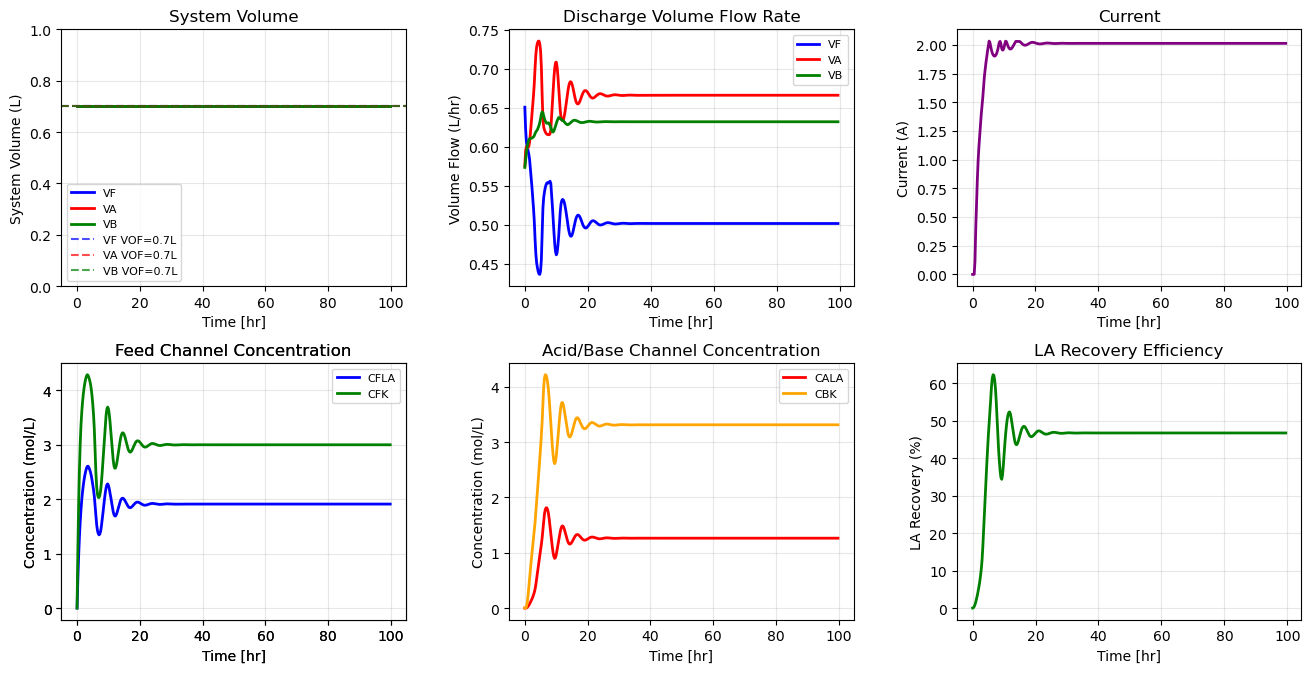

In [13]:
# Visualization
fig = plt.figure(figsize=(16,12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sim_res['time'], sim_res['VF'], 'b-', label='VF', linewidth=2)
ax1.plot(sim_res['time'], sim_res['VA'], 'r-', label='VA', linewidth=2)
ax1.plot(sim_res['time'], sim_res['VB'], 'g-', label='VB', linewidth=2)
ax1.axhline(y=cond_init[2], color='b', linestyle='--', alpha=0.7, label=f'VF VOF={cond_init[2]}L')
ax1.axhline(y=cond_init[3], color='r', linestyle='--', alpha=0.7, label=f'VA VOF={cond_init[3]}L')
ax1.axhline(y=cond_init[4], color='g', linestyle='--', alpha=0.7, label=f'VB VOF={cond_init[4]}L')
ax1.set_xlabel('Time [hr]')
ax1.set_ylabel('System Volume (L)')
ax1.set_title('System Volume')
ax1.set_ylim([0,1])
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(discharge_data['time'], discharge_data['VF_out'], 'b-', label='VF', linewidth=2)
ax2.plot(discharge_data['time'], discharge_data['VA_out'], 'r-', label='VA', linewidth=2)
ax2.plot(discharge_data['time'], discharge_data['VB_out'], 'g-', label='VB', linewidth=2)
ax2.set_xlabel('Time [hr]')
ax2.set_ylabel('Volume Flow (L/hr)')
ax2.set_title('Discharge Volume Flow Rate')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(sim_res['time'], sim_res['I'], 'purple', linewidth=2)
ax3.set_xlabel('Time [hr]')
ax3.set_ylabel('Current (A)')
ax3.set_title('Current')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(sim_res['time'], sim_res['CFLA'], 'b-', label='CFLA (Feed LA)', linewidth=2)
ax4.plot(sim_res['time'], sim_res['CFK'], 'g-', label='CFK (Feed K)', linewidth=2)
ax4.set_xlabel('Time [hr]')
ax4.set_ylabel('Concentration (mol/L)')
ax4.set_title('Feed Channel Concentration')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(sim_res['time'], sim_res['CFLA'], 'b-', label='CFLA', linewidth=2)
ax4.plot(sim_res['time'], sim_res['CFK'], 'g-', label='CFK', linewidth=2)
ax4.set_xlabel('Time [hr]')
ax4.set_ylabel('Concentration (mol/L)')
ax4.set_title('Feed Channel Concentration')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(sim_res['time'], sim_res['CALA'], 'r-', label='CALA', linewidth=2)
ax5.plot(sim_res['time'], sim_res['CBK'], 'orange', label='CBK', linewidth=2)
ax5.set_xlabel('Time [hr]')
ax5.set_ylabel('Concentration (mol/L)')
ax5.set_title('Acid/Base Channel Concentration')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
input_LA_rate = cond_flow[0]/0.25 * cond_flow[3]  # mol/step
recovery_efficiency = np.array(discharge_data['NALA_out']) / input_LA_rate * 100
ax6.plot(discharge_data['time'], recovery_efficiency, 'green', linewidth=2)
ax6.set_xlabel('Time [hr]')
ax6.set_ylabel('LA Recovery (%)')
ax6.set_title('LA Recovery Efficiency')
ax6.grid(True, alpha=0.3)


In [14]:
print(f'VF_in: {cond_flow[0]/0.25}')
print(f'VA_in: {cond_flow[1]/0.25}')
print(f'VB_in: {cond_flow[2]/0.25}')
print(f'TotalV_in: {cond_flow[0]/0.25 + cond_flow[1]/0.25 + cond_flow[2]/0.25}')
print(f'VF_out: {discharge_data["VF_out"][-1]}')
print(f'VA_out: {discharge_data["VA_out"][-1]}')
print(f'VB_out: {discharge_data["VB_out"][-1]}')
print(f'TotalV_out: {discharge_data["VF_out"][-1] + discharge_data["VA_out"][-1] + discharge_data["VB_out"][-1]}')
print('\n')
print(f'NFLA_in: {cond_flow[0]/0.25 * cond_flow[3]}')
print(f'NFLA_out: {discharge_data["NFLA_out"][-1]}')
print(f'NALA_out: {discharge_data["NALA_out"][-1]}')
print(f'TotalLA_out: {discharge_data["NFLA_out"][-1] + discharge_data["NALA_out"][-1]}')
print('\n')
print(f'CFLA_in: {cond_flow[0]/0.25 * cond_flow[3]}')
print(f'CFLA_out: {discharge_data["CFLA_out"][-1]}')
print('\n')
print(f'CFK_in: {cond_flow[0]/0.25 * cond_flow[4]}')
print(f'CFK_out: {discharge_data["CFK_out"][-1]}')
print('\n')
print(f'CBK_in: {cond_flow[0]/0.25 * cond_flow[4]}')
print(f'CBK_out: {discharge_data["CBK_out"][-1]}')
print('\n')
print(f'NFK_in: {cond_flow[0]/0.25 * cond_flow[4]}')
print(f'NFK_out: {discharge_data["NFK_out"][-1]}')
print(f'NBK_out: {discharge_data["NBK_out"][-1]}')
print(f'TotalK_out: {discharge_data["NFK_out"][-1] + discharge_data["NBK_out"][-1]}')



VF_in: 0.6
VA_in: 0.6
VB_in: 0.6
TotalV_in: 1.7999999999999998
VF_out: 0.5016348361968994
VA_out: 0.6661946773529053
VB_out: 0.6321704387664795
TotalV_out: 1.7999999523162842


NFLA_in: 1.7999999999999998
NFLA_out: 0.9581055045127869
NALA_out: 0.8418947458267212
TotalLA_out: 1.800000250339508


CFLA_in: 1.7999999999999998
CFLA_out: 1.909965991973877


CFK_in: 3.5999999999999996
CFK_out: 2.999044179916382


CBK_in: 3.5999999999999996
CBK_out: 3.3148889541625977


NFK_in: 3.5999999999999996
NFK_out: 1.504425048828125
NBK_out: 2.0955748558044434
TotalK_out: 3.5999999046325684


In [15]:
#Performance calculation
I_st = sim_res['I'][160:180] # A = C/s
C_st = 3600*I_st # C/hr
CE_st = np.array(discharge_data['NALA_out'][160:180])*96485/10/C_st*100 # %
Fm_st = np.array(discharge_data['NALA_out'][160:180])*90.1 # g/hr
SEC_st = cond_init[0]*I_st/Fm_st # Wh/g = kWh/kg
t_st = 1000/Fm_st # hr/kg
E_pump = 0.0047*t_st # kWh/kg
VA_st = np.array(discharge_data['VA_out'][160:180]) # L/hr = kg/hr
E_dist = (VA_st *4.184*(100-25)*t_st + (VA_st - Fm_st/0.85/1000)*43.9*1000/18)/3600 # kWh/kg
RR_st = recovery_efficiency[160:180]
TotalE_st = SEC_st + E_pump + E_dist

df_pm = pd.DataFrame({
    'RR': np.round(RR_st, 3),
    'SEC': np.round(SEC_st, 3),
    'E_pump': np.round(E_pump, 3),
    'E_dist': np.round(E_dist, 3),
    'TotalE': np.round(TotalE_st, 3)
}).drop_duplicates()
df_pm = df_pm.sort_values(by='RR', ascending=False)
df_pm

,RR,SEC,E_pump,E_dist,TotalE
0,46.778,0.531,0.062,1.156,1.749
1,46.777,0.531,0.062,1.156,1.749
2,46.776,0.531,0.062,1.156,1.749
3,46.775,0.531,0.062,1.156,1.749
18,46.774,0.531,0.062,1.156,1.749
4,46.773,0.531,0.062,1.156,1.749
5,46.772,0.531,0.062,1.156,1.749
6,46.771,0.531,0.062,1.156,1.749
7,46.770,0.531,0.062,1.156,1.749
8,46.769,0.531,0.062,1.156,1.749


=== Input Flow Rates ===
H2O input rate: 100.000 mol/hr
LA input rate: 1.800 mol/hr
K input rate: 3.600 mol/hr

=== Steady State Mass Balance Check (t=40-45hr) ===
H2O balance error: -0.000 ± 0.000 %
LA balance error: -0.000 ± 0.001 %
K balance error: -0.000 ± 0.002 %


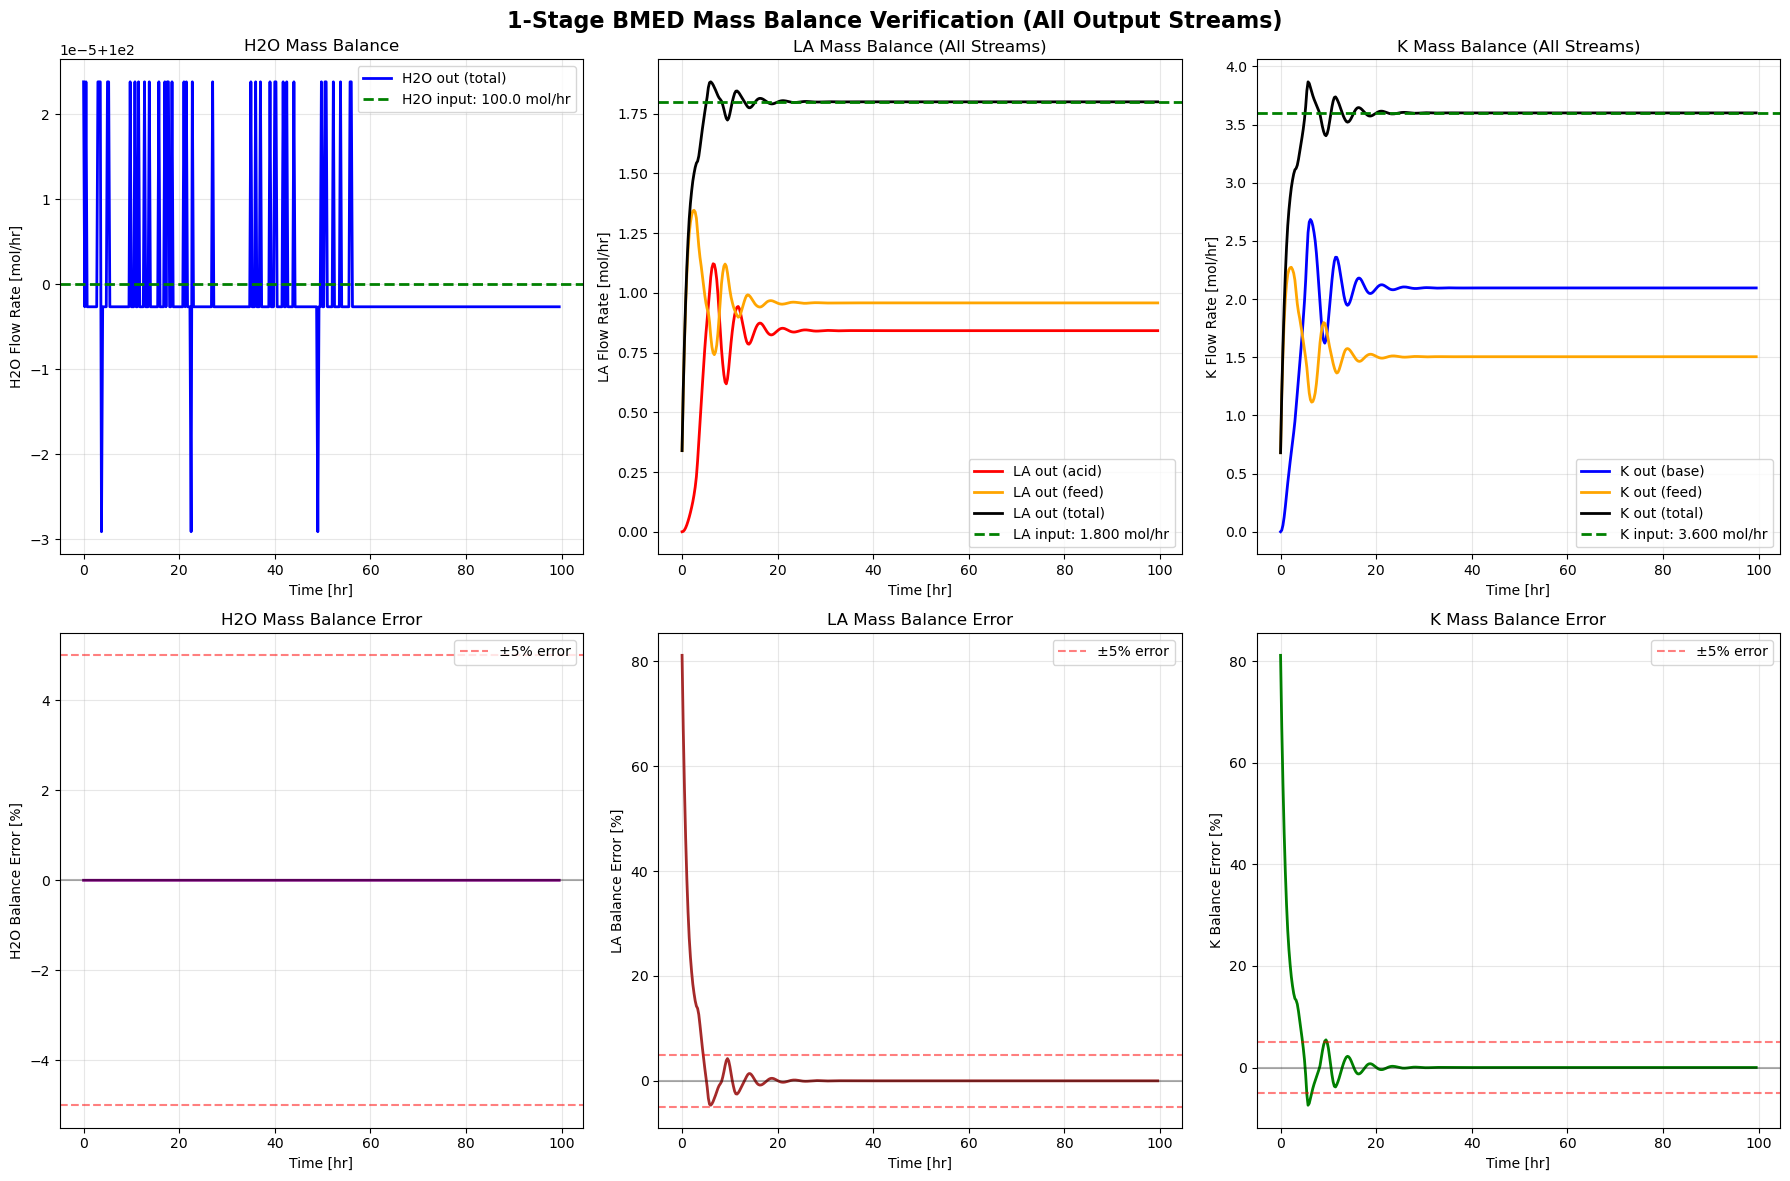


=== Separation Efficiency Analysis (Steady State) ===
LA Recovery (Acid channel): 46.77%
LA Loss (Feed channel): 53.23%
K Recovery (Base channel): 58.21%
K Loss (Feed channel): 41.79%

=== System Accumulation Analysis ===
Total accumulated H2O: 0.000 mol
Total accumulated LA: 2.222 mol
Total accumulated K: 4.420 mol

=== Complete Mass Balance Summary ===
  Component  Input Rate [mol/hr]  Output Rate [mol/hr] (SS)  \
0       H2O                100.0                      100.0   
1        LA                  1.8                        1.8   
2         K                  3.6                        3.6   

  Recovered [mol/hr] (SS) Feed Loss [mol/hr] (SS)  Balance Error [%] (SS)  \
0                       -                       -                 -0.0000   
1                0.841901                0.958103                 -0.0002   
2                2.095596                1.504415                 -0.0003   

  Recovery Efficiency [%]  
0                       -  
1               46.77216

In [16]:
# Mass Balance Verification for 1-Stage BMED System

## Calculate mass balance for H2O, K, and LA
# Time step = 0.25 hr, molecular weights: H2O=18 g/mol, K=39.1 g/mol, LA=90.1 g/mol

# Input flows (mol/hr)
QF_molhr = cond_flow[0] / 0.25  # L/hr
QA_molhr = cond_flow[1] / 0.25  # L/hr  
QB_molhr = cond_flow[2] / 0.25  # L/hr
CFLA_in = cond_flow[3]  # mol/L
CFK_in = cond_flow[4]   # mol/L

# Input rates (mol/hr)
input_H2O_rate = (QF_molhr + QA_molhr + QB_molhr) * 1000/18  # assuming water density ~1000g/L
input_LA_rate = QF_molhr * CFLA_in  # mol/hr
input_K_rate = QF_molhr * CFK_in    # mol/hr

print(f"=== Input Flow Rates ===")
print(f"H2O input rate: {input_H2O_rate:.3f} mol/hr")
print(f"LA input rate: {input_LA_rate:.3f} mol/hr") 
print(f"K input rate: {input_K_rate:.3f} mol/hr")

# System outputs (mol/hr) - ALL OUTPUT STREAMS
H2O_out = [(discharge_data['VF_out'][i] + discharge_data['VA_out'][i] + discharge_data['VB_out'][i]) * 1000/18 for i in range(len(discharge_data['VF_out']))]

# LA outputs: Acid channel (recovered) + Feed channel (remaining)
LA_out_acid = discharge_data['NALA_out']    # mol/hr (LA recovered in acid channel)
LA_out_feed = discharge_data['NFLA_out']    # mol/hr (LA remaining in feed channel)
LA_out_total = [LA_out_acid[i] + LA_out_feed[i] for i in range(len(LA_out_acid))]

# K outputs: Base channel (recovered) + Feed channel (remaining) 
K_out_base = discharge_data['NBK_out']      # mol/hr (K recovered in base channel)
K_out_feed = discharge_data['NFK_out']      # mol/hr (K remaining in feed channel)
K_out_total = [K_out_base[i] + K_out_feed[i] for i in range(len(K_out_base))]

# Mass balance errors (%)
H2O_balance_error = [(input_H2O_rate - H2O_out[i])/input_H2O_rate * 100 for i in range(len(H2O_out))]
LA_balance_error = [(input_LA_rate - LA_out_total[i])/input_LA_rate * 100 for i in range(len(LA_out_total))]
K_balance_error = [(input_K_rate - K_out_total[i])/input_K_rate * 100 for i in range(len(K_out_total))]

print(f"\n=== Steady State Mass Balance Check (t=40-45hr) ===")
ss_start, ss_end = 160, 180  # steady state region
print(f"H2O balance error: {np.mean(H2O_balance_error[ss_start:ss_end]):.3f} ± {np.std(H2O_balance_error[ss_start:ss_end]):.3f} %")
print(f"LA balance error: {np.mean(LA_balance_error[ss_start:ss_end]):.3f} ± {np.std(LA_balance_error[ss_start:ss_end]):.3f} %")
print(f"K balance error: {np.mean(K_balance_error[ss_start:ss_end]):.3f} ± {np.std(K_balance_error[ss_start:ss_end]):.3f} %")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('1-Stage BMED Mass Balance Verification (All Output Streams)', fontsize=16, fontweight='bold')

# H2O Mass Balance
axes[0,0].plot(discharge_data['time'], H2O_out, 'b-', label='H2O out (total)', linewidth=2)
axes[0,0].axhline(y=input_H2O_rate, color='g', linestyle='--', label=f'H2O input: {input_H2O_rate:.1f} mol/hr', linewidth=2)
axes[0,0].set_xlabel('Time [hr]')
axes[0,0].set_ylabel('H2O Flow Rate [mol/hr]')
axes[0,0].set_title('H2O Mass Balance')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# LA Mass Balance - All Streams
axes[0,1].plot(discharge_data['time'], LA_out_acid, 'r-', label='LA out (acid)', linewidth=2)
axes[0,1].plot(discharge_data['time'], LA_out_feed, 'orange', label='LA out (feed)', linewidth=2)
axes[0,1].plot(discharge_data['time'], LA_out_total, 'k-', label='LA out (total)', linewidth=2)
axes[0,1].axhline(y=input_LA_rate, color='g', linestyle='--', label=f'LA input: {input_LA_rate:.3f} mol/hr', linewidth=2)
axes[0,1].set_xlabel('Time [hr]')
axes[0,1].set_ylabel('LA Flow Rate [mol/hr]')
axes[0,1].set_title('LA Mass Balance (All Streams)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# K Mass Balance - All Streams
axes[0,2].plot(discharge_data['time'], K_out_base, 'b-', label='K out (base)', linewidth=2)
axes[0,2].plot(discharge_data['time'], K_out_feed, 'orange', label='K out (feed)', linewidth=2)
axes[0,2].plot(discharge_data['time'], K_out_total, 'k-', label='K out (total)', linewidth=2)
axes[0,2].axhline(y=input_K_rate, color='g', linestyle='--', label=f'K input: {input_K_rate:.3f} mol/hr', linewidth=2)
axes[0,2].set_xlabel('Time [hr]')
axes[0,2].set_ylabel('K Flow Rate [mol/hr]')
axes[0,2].set_title('K Mass Balance (All Streams)')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Mass Balance Errors
axes[1,0].plot(discharge_data['time'], H2O_balance_error, 'purple', linewidth=2)
axes[1,0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,0].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='±5% error')
axes[1,0].axhline(y=-5, color='r', linestyle='--', alpha=0.5)
axes[1,0].set_xlabel('Time [hr]')
axes[1,0].set_ylabel('H2O Balance Error [%]')
axes[1,0].set_title('H2O Mass Balance Error')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(discharge_data['time'], LA_balance_error, 'brown', linewidth=2)
axes[1,1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,1].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='±5% error')
axes[1,1].axhline(y=-5, color='r', linestyle='--', alpha=0.5)
axes[1,1].set_xlabel('Time [hr]')
axes[1,1].set_ylabel('LA Balance Error [%]')
axes[1,1].set_title('LA Mass Balance Error')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

axes[1,2].plot(discharge_data['time'], K_balance_error, 'green', linewidth=2)
axes[1,2].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,2].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='±5% error')
axes[1,2].axhline(y=-5, color='r', linestyle='--', alpha=0.5)
axes[1,2].set_xlabel('Time [hr]')
axes[1,2].set_ylabel('K Balance Error [%]')
axes[1,2].set_title('K Mass Balance Error')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Separation efficiency analysis
print(f"\n=== Separation Efficiency Analysis (Steady State) ===")
LA_recovery_eff = np.mean([LA_out_acid[i]/LA_out_total[i]*100 for i in range(ss_start, ss_end)])
LA_feed_loss = np.mean([LA_out_feed[i]/LA_out_total[i]*100 for i in range(ss_start, ss_end)])

K_recovery_eff = np.mean([K_out_base[i]/K_out_total[i]*100 for i in range(ss_start, ss_end)])
K_feed_loss = np.mean([K_out_feed[i]/K_out_total[i]*100 for i in range(ss_start, ss_end)])

print(f"LA Recovery (Acid channel): {LA_recovery_eff:.2f}%")
print(f"LA Loss (Feed channel): {LA_feed_loss:.2f}%")
print(f"K Recovery (Base channel): {K_recovery_eff:.2f}%")
print(f"K Loss (Feed channel): {K_feed_loss:.2f}%")

# Accumulation analysis
print(f"\n=== System Accumulation Analysis ===")
H2O_accumulation = [input_H2O_rate - H2O_out[i] for i in range(len(H2O_out))]
LA_accumulation = [input_LA_rate - LA_out_total[i] for i in range(len(LA_out_total))]
K_accumulation = [input_K_rate - K_out_total[i] for i in range(len(K_out_total))]

# Cumulative accumulation over time
H2O_cumulative = np.cumsum(H2O_accumulation) * 0.25  # mol accumulated
LA_cumulative = np.cumsum(LA_accumulation) * 0.25    # mol accumulated
K_cumulative = np.cumsum(K_accumulation) * 0.25      # mol accumulated

print(f"Total accumulated H2O: {H2O_cumulative[-1]:.3f} mol")
print(f"Total accumulated LA: {LA_cumulative[-1]:.3f} mol")
print(f"Total accumulated K: {K_cumulative[-1]:.3f} mol")

# Summary DataFrame
mass_balance_summary = pd.DataFrame({
    'Component': ['H2O', 'LA', 'K'],
    'Input Rate [mol/hr]': [input_H2O_rate, input_LA_rate, input_K_rate],
    'Output Rate [mol/hr] (SS)': [
        np.mean(H2O_out[ss_start:ss_end]),
        np.mean(LA_out_total[ss_start:ss_end]), 
        np.mean(K_out_total[ss_start:ss_end])
    ],
    'Recovered [mol/hr] (SS)': [
        '-',
        np.mean(LA_out_acid[ss_start:ss_end]),
        np.mean(K_out_base[ss_start:ss_end])
    ],
    'Feed Loss [mol/hr] (SS)': [
        '-',
        np.mean(LA_out_feed[ss_start:ss_end]),
        np.mean(K_out_feed[ss_start:ss_end])
    ],
    'Balance Error [%] (SS)': [
        np.mean(H2O_balance_error[ss_start:ss_end]),
        np.mean(LA_balance_error[ss_start:ss_end]),
        np.mean(K_balance_error[ss_start:ss_end])
    ],
    'Recovery Efficiency [%]': [
        '-',
        LA_recovery_eff,
        K_recovery_eff
    ]
})

print(f"\n=== Complete Mass Balance Summary ===")
print(mass_balance_summary.round(4))

# Validation check
LA_balance_avg = np.mean(LA_balance_error[ss_start:ss_end])
K_balance_avg = np.mean(K_balance_error[ss_start:ss_end])
H2O_balance_avg = np.mean(H2O_balance_error[ss_start:ss_end])

print(f"\n=== Mass Balance Validation ===")
if abs(LA_balance_avg) < 5.0 and abs(K_balance_avg) < 5.0 and abs(H2O_balance_avg) < 5.0:
    print("✅ Mass balance validation PASSED for all components (error < 5%)")
else:
    print("❌ Mass balance validation FAILED for some components (error ≥ 5%)")
    if abs(LA_balance_avg) >= 5.0:
        print(f"   - LA balance error: {LA_balance_avg:.2f}%")
    if abs(K_balance_avg) >= 5.0:
        print(f"   - K balance error: {K_balance_avg:.2f}%")
    if abs(H2O_balance_avg) >= 5.0:
        print(f"   - H2O balance error: {H2O_balance_avg:.2f}%")